In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
warnings.simplefilter("ignore")

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {}
entries = ["Nuclear Repulsion  :", \
        "One Electron Energy:", \
        "Two Electron Energy:", \
        "Potential Energy   :", \
        "Kinetic Energy     :", \
        "E(X)               :"  , \
        "E(C)               :"  , \
        "Dispersion correction", \
        "FINAL SINGLE POINT ENERGY"]
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
basis_sets = ["MINIX", "SVP", "TZVP"]
for func in functionals:
    for basis in basis_sets:
        methods[func + "-" + basis] = []
        for ebtry in entries:
            methods[func + "-" + basis].append(ebtry)

# read all the data and initialize the data structures
rootdir = "../datasets/AllData_3/"   
allvalues_perset, fullsetnames, models_results = \
        commonutils.read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestinsidemethod_wtmad:
            models_results[setname].bestinsidemethod_wtmad = wtmad
            models_results[setname].bestinsidemethod_name_wtmad = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
        wtmad = wtmadf["Full"]

        if wtmad < models_results[setname].bestourmethod_wtmad:
            models_results[setname].bestourmethod_wtmad = wtmad
            models_results[setname].bestourmethod_name_wtmad = method
            models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           0  ,    8.201  ,           0  ,    8.040  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,    4.970
                    BARRIER_HEIGHTS_BH76  ,           0  ,   10.387  ,           0  ,    9.150  ,   PBE0-TZVP  ,    5.505  ,   PBE0-TZVP  ,    5.000
                 BARRIER_HEIGHTS_BHDIV10  ,           0  ,    9.191  ,           0  ,    8.230  ,   PBE0-TZVP  ,    5.278  ,   PBE0-TZVP  ,    4.800
                  BARRIER_HEIGHTS_BHPERI  ,           0  ,    4.407  ,           0  ,    3.950  ,   PBE0-TZVP  ,    3.762  ,   PBE0-TZVP  ,    3.510
                 BARRIER_HEIGHTS_BHROT27  ,           1  ,    0.611  ,           1  ,    0.420  ,    PBE-TZVP  ,    0.718  ,    PBE-TZVP  ,    0.540
                   BARRIER_HE

In [5]:
#build descriptors 
selected_basisset = "TZVP"
selected_functional = "PBE"
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
for setname in fullsetnames:
    desciptors = {}
    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in basis_sets:
                if basis == selected_basisset and func == selected_functional:
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        if k2 not in desciptors:
                            desciptors[k2] = [val[k][k2]]
                        else:
                            desciptors[k2].append(val[k][k2])
                else:
                    refk  = selected_functional + "-" + selected_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        refk2 = k2.replace(basis, selected_basisset)
                        refk2 = refk2.replace(func, selected_functional)
                        newk2 = k2 + "_difftoref"
                        if newk2 not in desciptors:
                            desciptors[newk2] = [val[refk][refk2] - val[k][k2]]
                        else:
                            desciptors[newk2].append(val[refk][refk2] - val[k][k2])
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# feastures selection
setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

toremove = []
setname = "Full"
for k in models_results[setname].features:
    if len(set(models_results[setname].features[k])) == 1:
        toremove.append(k)
        print("Constant fatures to remove: ", k)

# remove constant values
for setname in fullsetnames:
    #print("Removing constant features for ", setname)
    for k in toremove:
        #print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
print("Removing Nuclear Repulsion difference")
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_difftoref") != -1:
            toremove.append(k)
    for k in toremove:
        #print("Removing feature ", k)
        del models_results[setname].features[k]

setname = "Full"
numoffeat = len(models_results[setname].features)
print("Number of features for ", numoffeat)
for setname in fullsetnames:
    if len(models_results[setname].features) != numoffeat:
        print("Number of features for ", setname, " is different")
        sys.exit(1)

Number of features for  108
Constant fatures to remove:  PBE-MINIX_Dispersion_correction_difftoref
Constant fatures to remove:  PBE-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE-SVP_Dispersion_correction_difftoref
Constant fatures to remove:  PBE0-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  PBE0-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSS-TZVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-SVP_Nuclear_Repulsion_difftoref
Constant fatures to remove:  TPSSh-TZVP_Nuclear_Repulsion_difftoref
Removing Nuclear Repulsion difference
Number of features for  95


In [6]:
# remove corralted features 
CORRCUT = 0.95

setname = "Full"
touse = []
toremove = []
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for i, k in enumerate(corr.columns):
    print(i+1, " - ", k, " ", i)
    if k not in toremove:
        touse.append(k)
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and idx > i:
            print(" %60s %4.2f"%(corr.index[idx], v))
            toremove.append(corr.index[idx])

print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

1  -  PBE-MINIX_Two_Electron_Energy_difftoref   0
                      PBE-MINIX_One_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_Two_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_One_Electron_Energy_difftoref 1.00
2  -  PBE-MINIX_E(C)_difftoref   1
                                    PBE0-MINIX_E(C)_difftoref 1.00
3  -  PBE-MINIX_One_Electron_Energy_difftoref   2
                     PBE0-MINIX_Two_Electron_Energy_difftoref 1.00
                     PBE0-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_One_Electron_Energy_difftoref 1.00
                     TPSS-MINIX_Two_Electron_Energy_difftoref 1.00
                    TPSSh-MINIX_Two_Electron_Energy_difftoref

Correlation matrix


<Axes: >

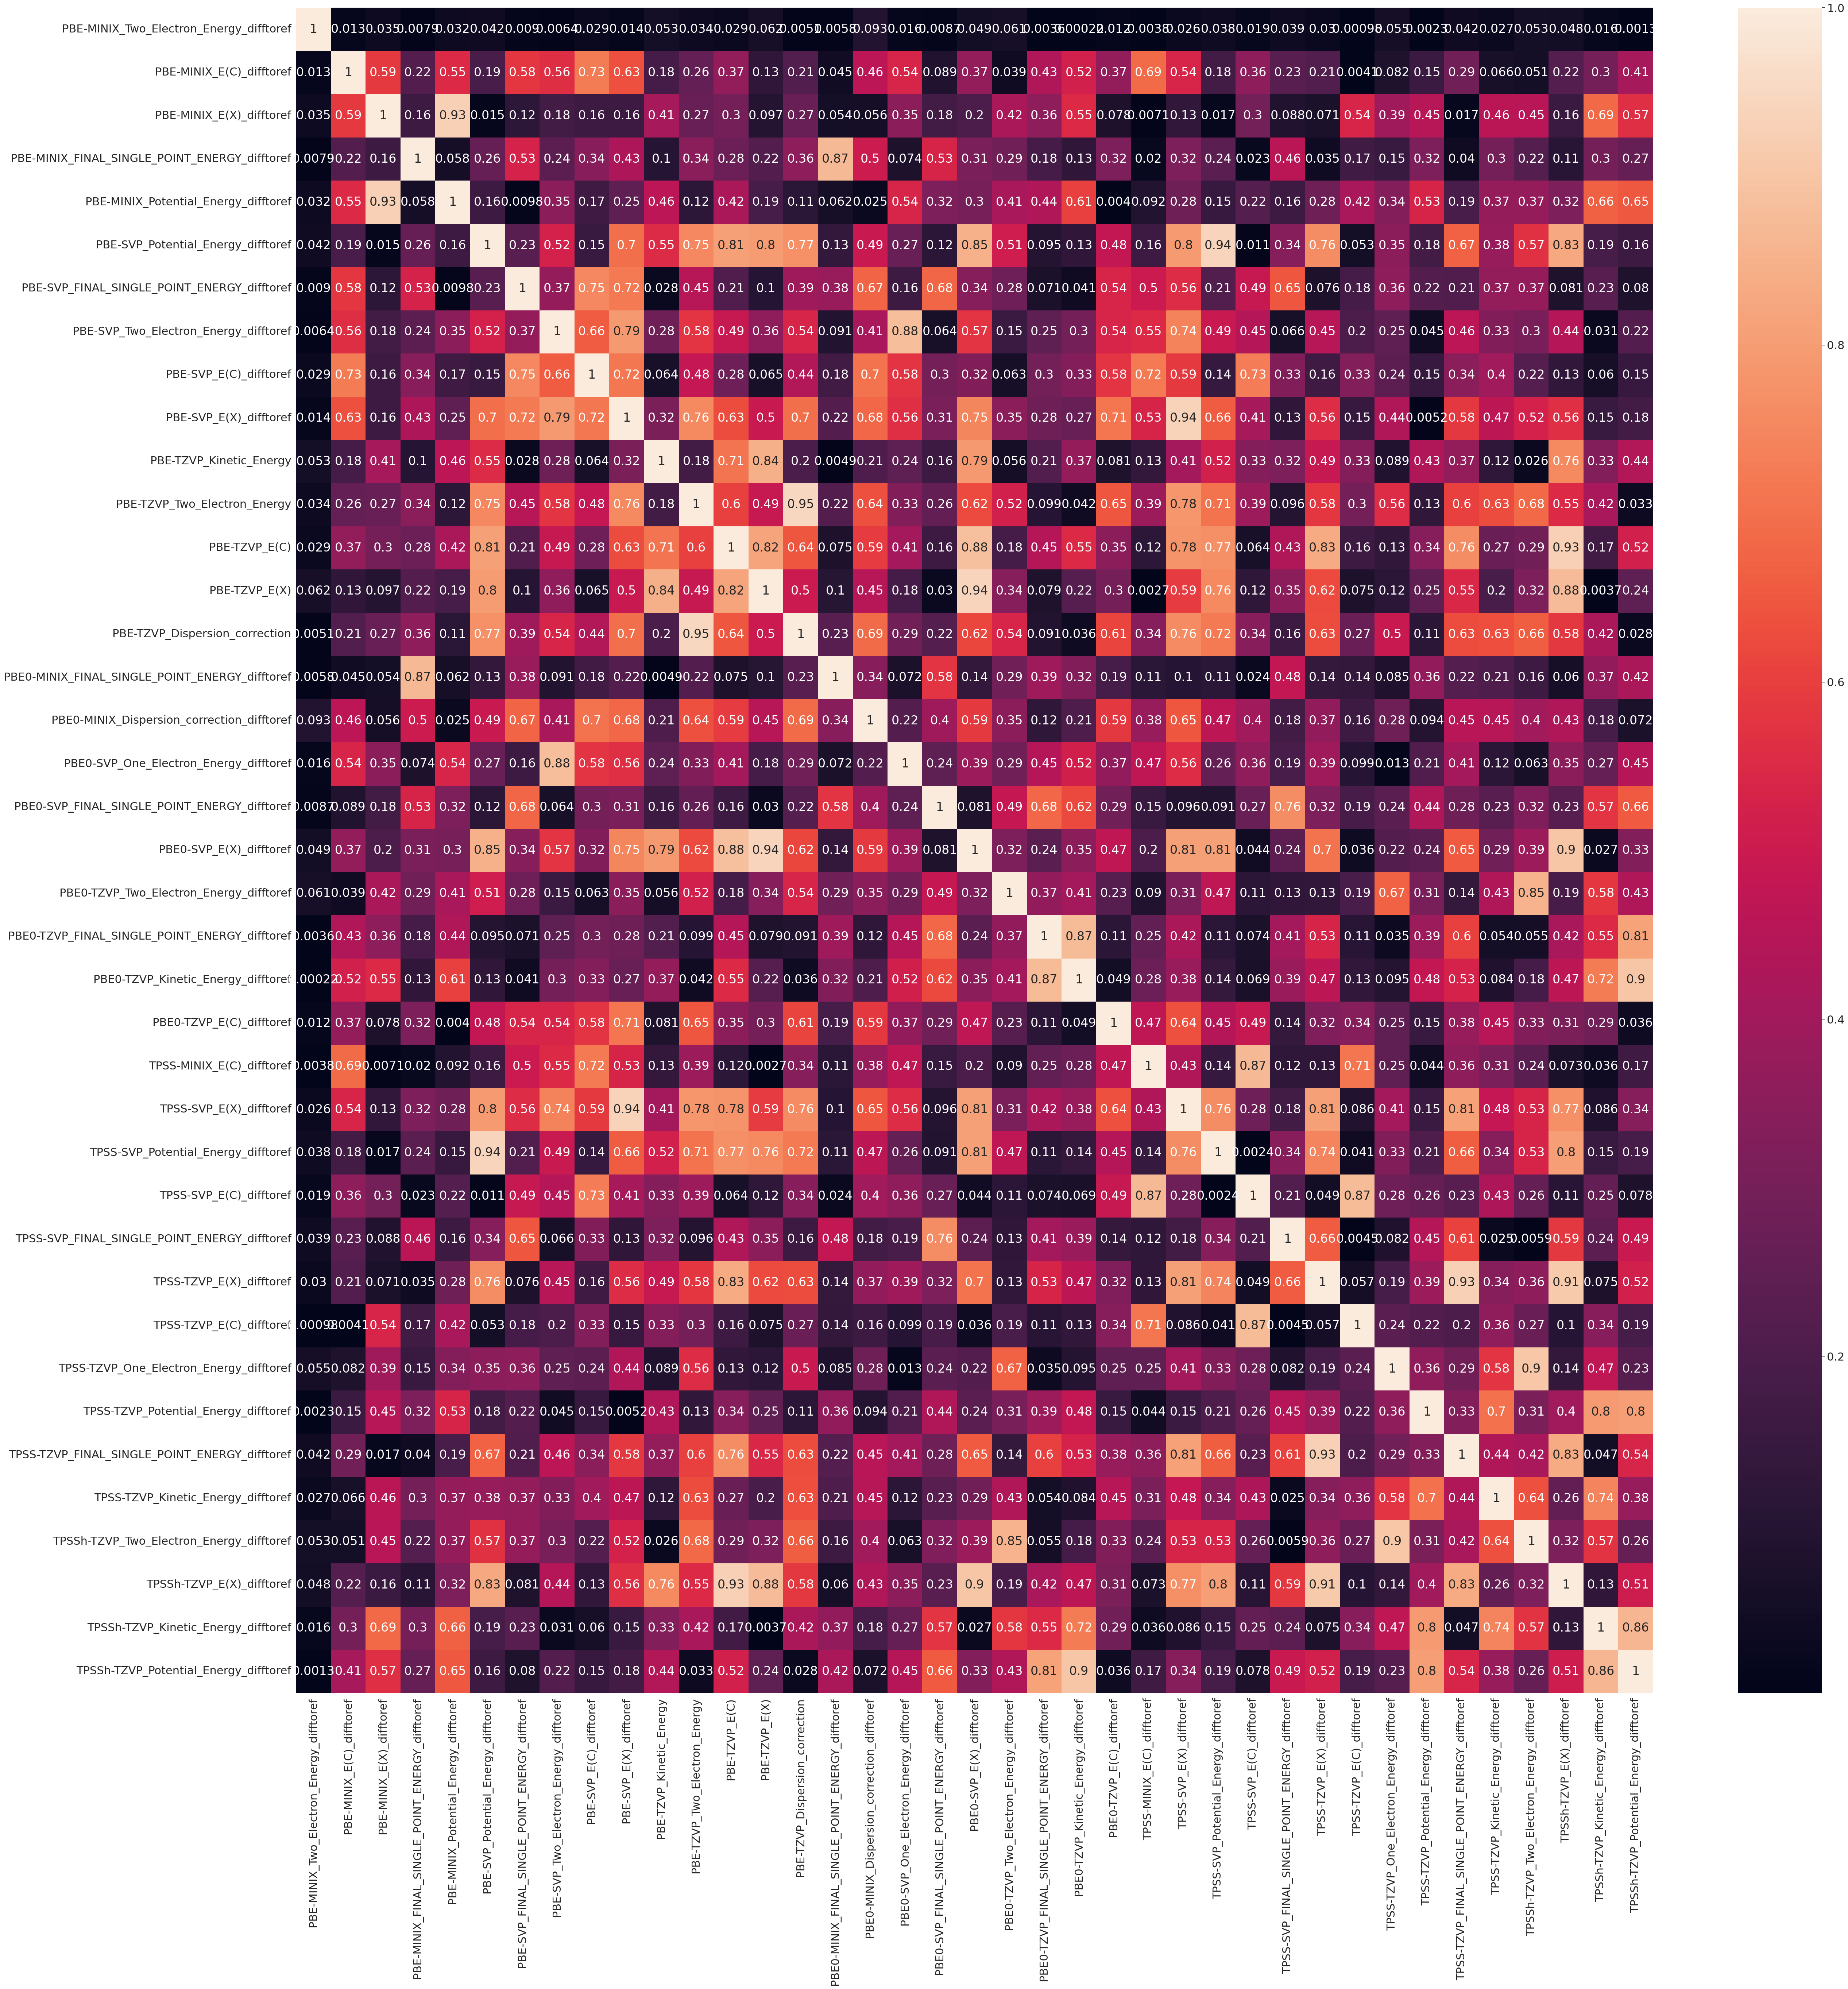

In [7]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [8]:
# test two linear models to predict energudiff
# LinearRegression
"""
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?
"""

'\nimport sklearn.linear_model as lm\nlinearNR_Two = lm.LinearRegression()\nlinearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1),                   df["PBE_Two_Electron_Energy"])\nprint(linearNR_Two.coef_, linearNR_Two.intercept_)\nlinearNR_One = lm.LinearRegression()\nlinearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1),                  df["PBE_One_Electron_Energy"])\nprint(linearNR_One.coef_, linearNR_One.intercept_)\n\nOnepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))\nTwopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))\n\n# scatter plot\nplt.clf()\nplt.scatter(df["PBE_One_Electron_Energy"], Onepred)\nplt.xlabel(\'Calculated Energy\')\nplt.ylabel(\'Predicted Energy\')\nplt.title(\'One Electron Energy\')\nplt.show()\n\nplt.clf()\nplt.scatter(df["PBE_Two_Electron_Energy"], Twopred)\nplt.xlabel(\'Calculated Energy\')\nplt.ylabel(\'Predicted Energy\')\nplt.title(\'Two Electron Energy\')\nplt.show()\n\

In [9]:
# force reload of models
import importlib
importlib.reload(models)
# search for the best model a simple grid search
nepochs = [50, 100]
#nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
"""
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
"""
modelshapes = [\
    [32, 32, 32, 32],\
    [64, 64, 64, 64],\
    [128, 128, 128, 128],\
    [32, 32, 32, 32, 32, 32],\
    [64, 64, 64, 64, 64, 64],\
    [128, 128, 128, 128, 128, 128], \
    [32, 32, 64, 128, 64, 32, 32, 24],\
    [64, 128, 256, 128, 64, 32],\
    [32, 64, 128, 128, 128, 64, 32, 24]]
setname = "Full"
print("Searching for best NN model for set: ", setname)
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                            models_results[setname].labels)

setlist = []
for i, s in enumerate(models_results[setname].setnames):
    ss = models_results[setname].supersetnames[i]
    setlist.append(ss + "_" + s)   
supersetlist = models_results[setname].supersetnames

scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminmape, modelminwtmad, modelminrmse  = \
        models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
            supersetlist, setlist, \
            nepochs, modelshapes, batch_sizes, inputshape=-1,\
            search=True, split=False)

print("Best NN model for set: ", setname, file=sys.stderr)
print("  WTAMD: ", modelminwtmad, file=sys.stderr)
print("   MAPE: ", modelminmape, file=sys.stderr)
print("   RMSE: ", modelminrmse, file=sys.stderr)

Searching for best NN model for set:  Full


AttributeError: module 'commonutils' has no attribute 'wtmad_calc'

In [ ]:
import importlib
importlib.reload(models)

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].uncorrelated_features , \
                                models_results[setname].labels)

setlist = []
for i, s in enumerate(models_results[setname].setnames):
    ss = models_results[setname].supersetnames[i]
    setlist.append(ss + "_" + s)   
supersetlist = models_results[setname].supersetnames

scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
#build the final model and print the results
results_mape = models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
                    supersetlist, setlist, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False, split=False)
        
models_results[setname].nn_model_mape = results_mape

results_wtmad = models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
                    supersetlist, setlist, \
                    [modelminwtmad[1]], \
                    [modelminwtmad[0]], \
                    [modelminwtmad[2]], \
                    inputshape=-1,\
                    search=False, split=False)
        
models_results[setname].nn_model_wtmad = results_wtmad

results_rmse = models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
                    supersetlist, setlist, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False, split=False)

models_results[setname].nn_model_rmse = results_rmse

In [ ]:
setname = "Full"
results_mape = models_results[setname].nn_model_mape
results_wtmad = models_results[setname].nn_model_wtmad
results_rmse = models_results[setname].nn_model_rmse

for history in [results_mape['history'], results_wtmad['history'], results_rmse['history']]:
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    plt.plot(history.history['mape'])
    plt.plot(history.history['val_mape'])
    plt.title('model MAPE')
    plt.ylabel('MAPE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
setname = "Full"
results_mape = models_results[setname].nn_model_mape
results_wtmad = models_results[setname].nn_model_wtmad
results_rmse = models_results[setname].nn_model_rmse
print(" Dim , %40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE mape, ", \
    "RMSE wtmad, ", \
    "RMSE rmse")
for setname in fullsetnames:

    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))

    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse_mape = mean_squared_error(Y, y_pred_mape, squared=False)
    
    y_pred_wtmad = scalery.inverse_transform(results_wtmad['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_wtmad = y_pred_wtmad
    rmse_wtmad = mean_squared_error(Y, y_pred_wtmad, squared=False)

    y_pred_rmse = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_rmse = y_pred_rmse
    rmse_rmse = mean_squared_error(Y, y_pred_rmse, squared=False)
    
    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse_mape, " , ", \
        "%7.3f"%rmse_wtmad, " , ", \
        "%7.3f"%rmse_rmse)


In [ ]:
"""
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)
"""

In [ ]:
printonlysuperset = True

for setname in fullsetnames:
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]

    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    setlist = []
    for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
    supersetlist = models_results[setname].supersetnames
    
    y_pred_wtmad = models_results[setname].y_pred_wtmad 
    rmse_wtmad = mean_squared_error(Y, y_pred_wtmad, squared=False)
    y_pred_mape = models_results[setname].y_pred_mape
    rmse_mape = mean_squared_error(Y, y_pred_mape, squared=False)
    y_pred_rmse = models_results[setname].y_pred_rmse
    rmse_rmse = mean_squared_error(Y, y_pred_rmse, squared=False)
    
    if setname in supersetnames or setname == "Full":
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred_mape, \
                                      Y, includeFull = True)
        print("WTAMD2             (MAPE) %7.3f"%wtmad2["Full"])
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred_wtmad, \
                                      Y, includeFull = True)
        print("WTAMD2            (WTAMD) %7.3f"%wtmad2["Full"])
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred_rmse, \
                                      Y, includeFull = True)
        print("WTAMD2             (RMSE) %7.3f"%wtmad2["Full"])
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtmad) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtmad)

    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE              (WTAMD) %7.3f"%rmse_wtmad)
    print("RMSE               (MAPE) %7.3f"%rmse_mape)
    print("RMSE               (RMSE) %7.3f"%rmse_rmse)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)


    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred_wtmad, \
               c='b', s=50, label='NN Full model WTAMD')
    ax.scatter(Y, y_pred_mape, \
                c='r', s=50, label='NN Full model MAPE')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, y_pred_rmse, \
                c='black', s=50, label='NN Full model RMSE')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()